In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [ ]:
BATCH_SIZE = 64
LATENT_DIM = 2

In [ ]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Sampling

In [ ]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

## Encoder

In [ ]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [ ]:
latent_inputs = Input(shape=(LATENT_DIM,))


x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Overall VAE Model

In [ ]:
vae_input = Input(shape=(28,28,1), name="vae_input")
z,_,_ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


In [ ]:
for i in range(3):
  print(vae.layers[i])

# Training

In [ ]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

In [ ]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [ ]:
def neuralearn(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [ ]:
neuralearn(EPOCHS)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(194.31403, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(174.37093, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(155.62276, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(160.26765, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(151.0081, shape=(), dtype=float32)
Training starts for epoch number 6
Training Loss is:  tf.Tensor(148.91473, shape=(), dtype=float32)
Training starts for epoch number 7
Training Loss is:  tf.Tensor(153.28786, shape=(), dtype=float32)
Training starts for epoch number 8
Training Loss is:  tf.Tensor(150.58101, shape=(), dtype=float32)
Training starts for epoch number 9
Training Loss is:  tf.Tensor(162.43623, shape=(), dtype=float32)
Training starts for epoch number 10
Training Loss is:  tf.Tensor(164.80823, shape=(), dtype=float32)


## Overriding train_step method

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def compile(self,optmizer,loss,*args,**kwargs):
    self.optmizer=optmizer
    self.loss=loss
    super().compile(*args,**kwargs)
  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = self.loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [ ]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=150,batch_size=128,)

Epoch 1/150
547/547 [==============================] - 8s 12ms/step - loss: 142.4639
Epoch 2/150
547/547 [==============================] - 4s 8ms/step - loss: 142.5600
Epoch 3/150
547/547 [==============================] - 4s 8ms/step - loss: 142.5742
Epoch 4/150
547/547 [==============================] - 4s 8ms/step - loss: 142.5305
Epoch 5/150
547/547 [==============================] - 4s 8ms/step - loss: 142.5105
Epoch 6/150
547/547 [==============================] - 5s 8ms/step - loss: 142.4741
Epoch 7/150
547/547 [==============================] - 4s 8ms/step - loss: 142.4662
Epoch 8/150
547/547 [==============================] - 4s 8ms/step - loss: 142.4380
Epoch 9/150
547/547 [==============================] - 5s 8ms/step - loss: 142.4200
Epoch 10/150
547/547 [==============================] - 4s 8ms/step - loss: 142.3987
Epoch 11/150
547/547 [==============================] - 4s 8ms/step - loss: 142.4248
Epoch 12/150
547/547 [==============================] - 4s 8ms/step - los

# Testing

In [ ]:
model.save_weights("vae.h5")

In [ ]:
scale=1
n=16

In [ ]:
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)

In [ ]:
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - ETA: 0s

KeyboardInterrupt: ignored

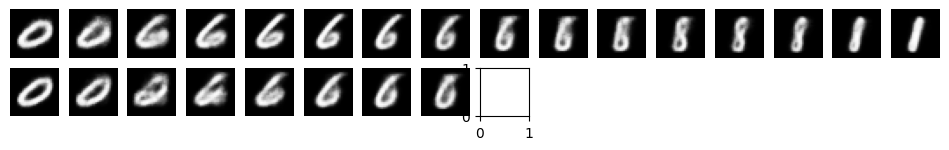

In [ ]:
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)

    input=tf.constant([[i,j]])
    out=model.decoder.predict(input)[0][...,0]
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1

In [ ]:
print(vae.layers[2].predict(tf.constant([[-1,1]]))[0][...,0].shape)

In [ ]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255

1875/1875 [==============================] - 3s 2ms/step


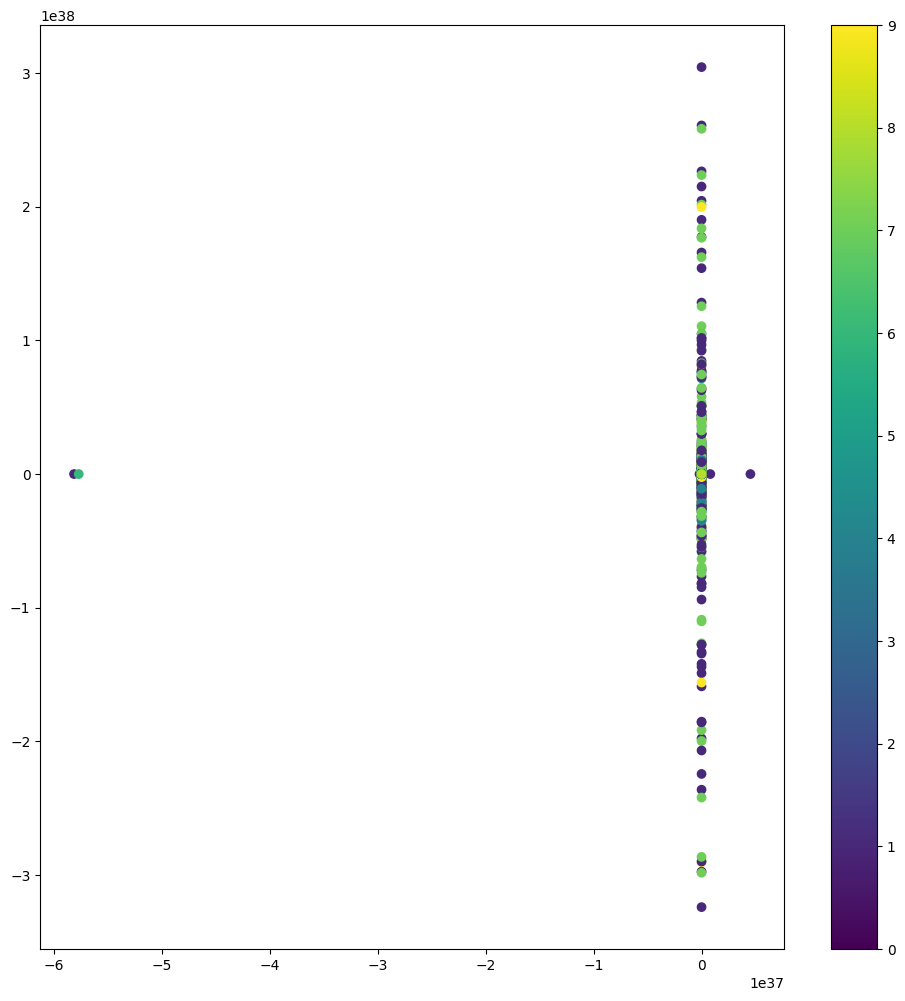

In [ ]:
z,_,_=vae.layers[1].predict(x_train)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=y_train)
plt.colorbar()
plt.show()

In [ ]:
z.shape

(60000, 2)

In [ ]:
from sklearn.cluster import KMeans
kme=KMeans(10,verbose=1,n_init=10)

In [ ]:
cast_val=tf.cast(z,dtype=tf.float32).numpy()

In [ ]:
tf.math.reduce_max(cast_val)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [ ]:
kme.fit(cast_val)

In [ ]:
set(kme.predict(z))

{0, 4, 5, 6, 7, 8, 9}

1/1 [==============================] - 0s 121ms/step


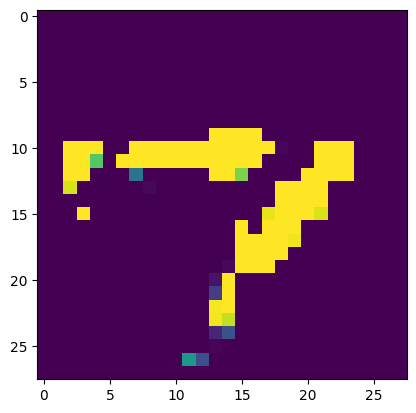

In [ ]:
plt.imshow(vae.layers[-1].predict([[50,50]])[0])

In [ ]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model_1 = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model_1.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [ ]:
latent_inputs = Input(shape=(LATENT_DIM,))


x = Dense(7*7*64, activation='relu')(latent_inputs)
x = Reshape((7,7,64))(x)

x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model_1 = Model(latent_inputs,decoder_output,name='decoder')
decoder_model_1.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_7 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289 

In [ ]:
import tensorflow_datasets as tfds
f_data=tfds.load(name="fashion_mnist",as_supervised=True)

In [ ]:
def rescaling(img,lab):
  return tf.cast(img,dtype=tf.float32)/255.

In [ ]:
resca_train=f_data["train"].map(rescaling)

In [ ]:
train_data_fashion=resca_train.shuffle(2000).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data_fashion

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model, decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]

  def compile(self,optmizer,loss,*args,**kwargs):
    self.optmizer=optmizer
    self.loss=loss
  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = self.encoder(x_batch)
      y_pred = self.decoder(z)
      y_true = x_batch
      loss = self.loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    self.optimizer.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [ ]:
custom_loss

<function __main__.custom_loss(y_true, y_pred, mean, log_var)>

In [ ]:

OPTIMIZER_1=tf.keras.optimizers.Adam(learning_rate=1e-3)
model=VAE(encoder_model_1,decoder_model_1)
model.compile(OPTIMIZER_1,custom_loss)
model.fit(train_data_fashion, epochs=150,batch_size=32,)

Epoch 1/150


TypeError: ignored